# Compute Time Distribution with Dask

In this notebook, I will use Dask to compute the number of posts for each Reddit flair to see if there is any specific distribution. I also calculate the mean of score for each flair.

In [60]:
import random
import dask
import os
from dask.distributed import Client
import dask.dataframe as dd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [1]:
client = Client()

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP st

In [4]:
client

Client Scheduler: tcp://127.0.0.1:53508 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.43 GB


In [6]:
os.getcwd()

'/home/jinfei/practice/personal-finance'

In [96]:
auto_df = dd.read_csv('data/flair/Auto.csv')
budgeting_df = dd.read_csv('data/flair/Budgeting.csv')
credit_df = dd.read_csv('data/flair/Credit.csv',engine='python', error_bad_lines=False)
debt_df = dd.read_csv('data/flair/Debt.csv',engine='python',error_bad_lines=False)
employment_df = dd.read_csv('data/flair/Employment.csv')
housing_df = dd.read_csv('data/flair/Housing.csv')
insurance_df = dd.read_csv('data/flair/Insurance.csv',engine='python',error_bad_lines=False)
investing_df = dd.read_csv('data/flair/Investing.csv',engine='python',error_bad_lines=False)
other_df = dd.read_csv('data/flair/Other.csv')
planning_df = dd.read_csv('data/flair/Planning.csv',engine='python',error_bad_lines=False)
retirement_df = dd.read_csv('data/flair/Retirement.csv',engine='python',error_bad_lines=False)
saving_df = dd.read_csv('data/flair/Saving.csv')
taxes_df = dd.read_csv('data/flair/Taxes.csv')

Skipping line 276: unexpected end of data


In [97]:
flair_dic = {'auto':auto_df,
            'budgeting':budgeting_df,
            'credit':credit_df,
            'debt':debt_df,
            'employment':employment_df,
            'housing':housing_df,
            'insurance':insurance_df,
            'investing':investing_df,
            'other':other_df,
            'planning':planning_df,
            'retirement':retirement_df,
            'saving':saving_df,
            'taxes':taxes_df}

In [10]:
flair_dic['taxes'].head()

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


,title,author,link_flair_css_class,selftext,url,score,created_utc
0,I converted my Roth IRA to a traditional IRA a...,hibbert0604,Taxes,"It's a long story, but my wife and I had to fi...",https://www.reddit.com/r/personalfinance/comme...,1,1584141894
1,Tax amendment question,p0ppab0n3r,Taxes,"Hey all, \n\n&amp;#x200B;\n\nThanks in advance...",https://www.reddit.com/r/personalfinance/comme...,1,1584140714
2,Got 1.2k less back than I filed for my Tax Ret...,hectormeow,Taxes,"Everything I can find online says\n\n""If the t...",https://www.reddit.com/r/personalfinance/comme...,1,1584139836
3,Wrong bank account number on federal tax form,ItsSamich,Taxes,"I only noticed this a couple days ago, but the...",https://www.reddit.com/r/personalfinance/comme...,1,1584137287
4,"per IRS withholding calculator, switching to r...",hinchfashion,Taxes,"Hey guys, I owed lotta tax in 2019 (around $4,...",https://www.reddit.com/r/personalfinance/comme...,1,1584137279


In [103]:
def draw_time_distribution(df,name=None):
    '''
    Draw a distribution of the posting time (format: %m-%d).
    Input: A Dask Dataframe
    '''
    # Convert 'created_utc' column to datetime objects
    df['created_datetime'] = dd.to_datetime(df['created_utc'],unit='s')
    # Use Parallel version of pandas.DataFrame.apply
    df['date'] = df['created_datetime'].apply(lambda x: x.strftime("%m-%d"),
                                             meta=('created_datetime', 'object'))
    posts_by_date = (df[['date', 'title']].groupby('date')
                                       .count()
                                       .rename(columns={'title':'count'}))
    posts_df = posts_by_date.compute() 
    
    sns.lineplot(x='date', y='count', data=posts_df)
    label = 'Posts Distribution across the Year'
    if name:
        label += f' for {name}'
    plt.title(label=label)
    plt.xticks(ticks=np.arange(0, len(posts_df),
            step=len(posts_df)//10),
             rotation=90)
    plt.xlabel('Date')  
    plt.ylabel('Number of Posts')  
    plt.show()

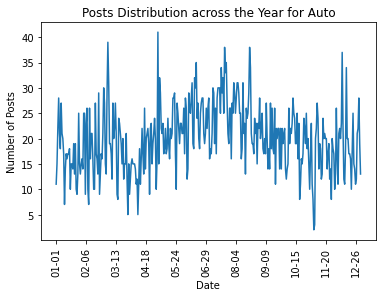

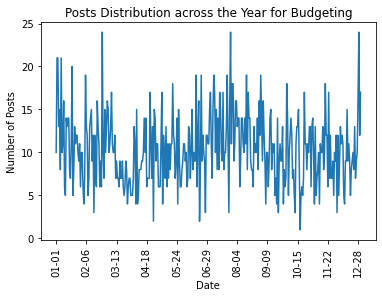

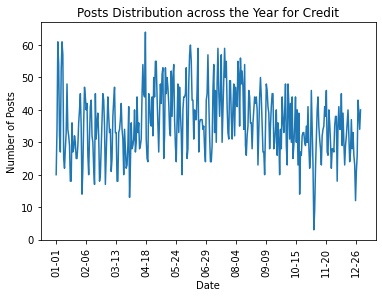

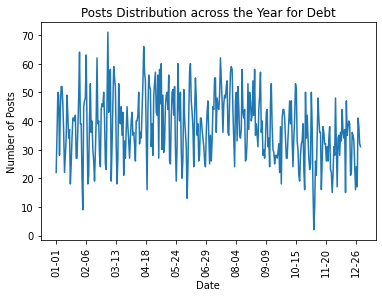

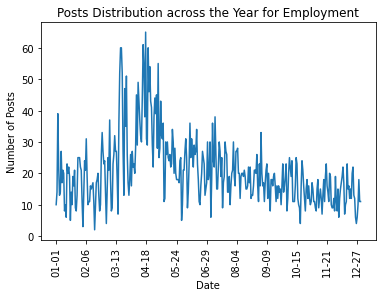

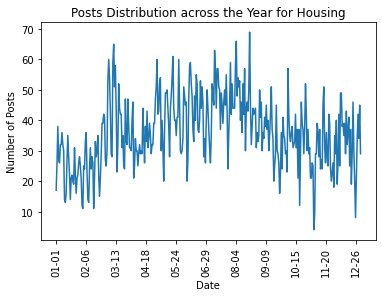

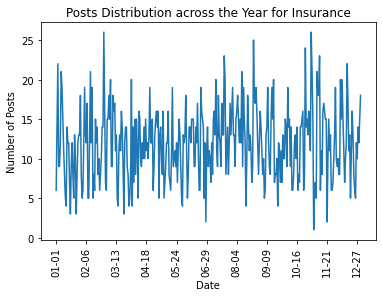

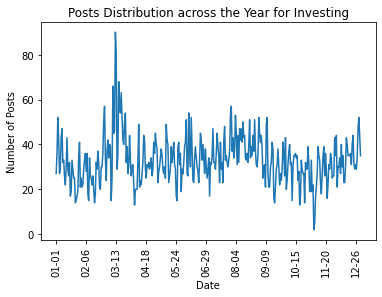

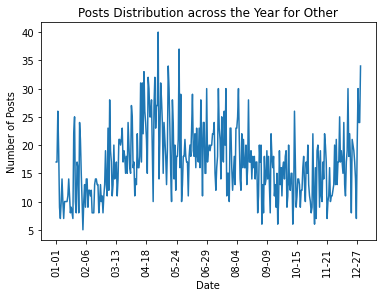

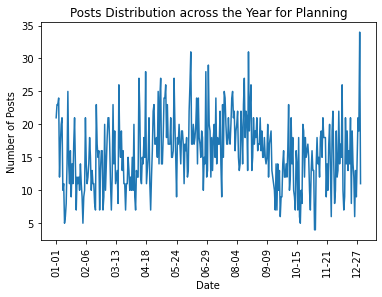

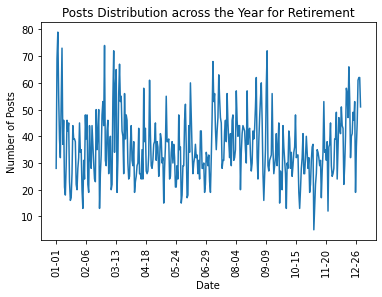

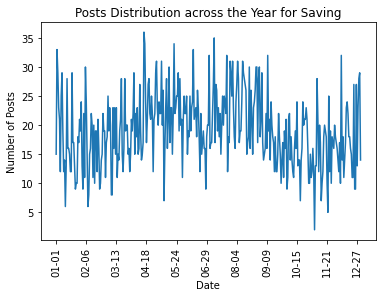

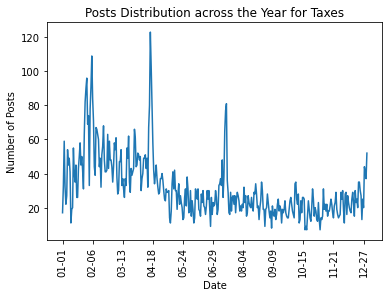

In [109]:
for key in flair_dic.keys():
    draw_time_distribution(flair_dic[key],name=key.capitalize())

From the time distribution, we could find several things:

- There is a peak for Employment topics. After Christmas and New Year Holiday, there is an increase of the posts in Employment category and it reaches a peak in March and April. In late April or early May, the discussion begins to cool down. This could be the reaction to the Pandemic in the United States.
- In 2020 March, there is a surge in the Investing category. This should be a reflection of the 2020 stock market crash, which was a major and sudden global stock market crash and began on 20 February 2020 and ended on 7 April.
- The heated discussion about Tax occurs at the beginning of the year, from February to Mid-April, and reaches its peak around Tax Day, April 15. There is a second high peak in early July, this is because federal income tax payments due date have been deferred to July 15 because of COVID-19.


In [56]:
flair_dic['taxes'][['score']].describe().compute()

,score
count,11515.000000
mean,1.145723
std,2.291496
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,123.000000


In [116]:
# I feel that this compute could be further delayed, but it's already fast enough
mean_dic = {}
for key in flair_dic.keys():
    mean_dic[key] = flair_dic[key][['score']].mean().compute()['score']

In [117]:
mean_dic

{'auto': 1.1290278536318952,
 'budgeting': 1.7257551669316376,
 'credit': 1.2797505893087977,
 'debt': 1.4795156261329854,
 'employment': 1.6450753032120484,
 'housing': 1.178167463751613,
 'insurance': 1.3024804777216352,
 'investing': 1.1388130121678668,
 'other': 1.6830176461065243,
 'planning': 1.2455802555575004,
 'retirement': 1.1781782536570653,
 'saving': 1.231563845050215,
 'taxes': 1.1457229700390794}

In [134]:
import pandas as pd
def dic_to_df(dic, column_lst):
    '''
    Turn a dictionary into list
    Example pd.DataFrame(list(flair_dic.items()), columns=['flair', 'count'])
    '''
    df = pd.DataFrame(list(dic.items()), columns=column_lst)
    return df

def draw_ordered_barplot(df, x, y, title):
    '''
    Example:
    sns.barplot(x='flair', y="count", data=flair_df.sort_values('count'))
    plt.xticks(rotation='vertical')
    plt.title(label='Ordered count of posts in each flair');
    '''
    sns.barplot(x=x, y=y, data=df.sort_values(by=x))
    plt.xticks(rotation='vertical')
    plt.title(label=title)
    plt.show()

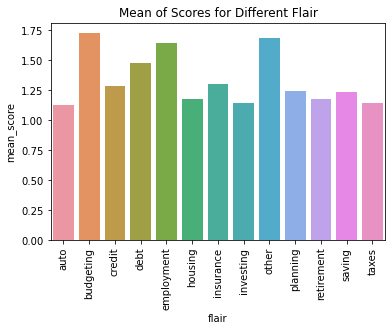

In [139]:
mean_df = dic_to_df(mean_dic, ['flair', 'mean_score']).sort_values(by='mean_score')
draw_ordered_barplot(mean_df, x='flair', y='mean_score', title='Mean of Scores for Different Flair')

Among all flair, the `budgeting` flair has the highest score, probably indicates that because people would like to share their experience and knowledge in `budgeting`, so readers would appreciate these kind of behavior and give higher score to those posts.